# What is the difference in average age of people who died from police shooting between African Americans and Caucasian Americans?

## Introduction

Police are one of the most important departments in a city because the order of the society is maintained by them. As society develops and grows, the power of these authorities becomes larger. However, police shooting has become a rising social issue, especially for African Americans. Finally, the death of George Floyd in Minneapolis, Minnesota triggered the outbreak of nationwide protests police violence (Deliso, 2021). Since people's concerns and criticism about police using deadly force are cumulating, some of the authorities released the data of police usage of force. Hence, tons of studies have been done and populated the literature in the police shooting area. Most of studies use whether police officers use force or not as the outcome of interest (e.g., Fyfe, 1982a; Geller & Karales, 1981; Milton, Halleck, Lardner, & Abrecht, 1977). Also, there are numbers of studies focus on the effect of race and the effect of age. Findings points out that African Americans has less chance to be shot compared to other races (Worrall et al., 2018) and police tends to use force against younger criminals over the old ones (Reiss, 1972; Terrill, 2005; Terrill & Mastrofski, 2002). However, there are limited papers stress the relationship between police violence victims' ages and the race of victim. Along with the deterioration of the relationship between young Americans and police (Solomon, 2016), it is also important to know if race plays a crucial role of causing young Americans deaths. In this study, the difference between the average age of Black people who were shot to death and the average age of White people was investigated. Based on the review of current literature, my hypothesis is that Black people are more likely to die from police shootings at an early age than White people on average.

The data used in this study comes from the University of Southern California and Campaign Zero. Datasets were merged to gain better insight. The outcome variable (Y) is the age variable which documents the age of people killed due to police shootings. The main independent variables (X) is race. Other independent variables are gender, state, year, mental illness issue, armed or not, geographic area. The rest of this report is organized by the following sections: Summary Statistics, Graphic Summary, Future Steps, and Conclusion.

# Project 1

## Summary Statistics

In [74]:
# Import libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib
import warnings
import re
import janitor
from matplotlib.pyplot import figure
from sklearn import (
    linear_model, metrics, pipeline, model_selection
)
from sklearn import tree
from sklearn.model_selection import train_test_split
import geopandas as gpd
from shapely.geometry import Point
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
import lmdiag

# Set up text size and font appears in the figure
font = {'weight' : 'bold',
        'size'   : 17}

matplotlib.rc('font', **font)


In [75]:
# read in the data as DataFrame
warnings.filterwarnings('ignore') # suppress warnings for aesthetic purposes
os.chdir("/Users/alex/Desktop/ECO225/ECO225Project/Data")
deaths_arrest = pd.read_csv("deaths_arrests.csv")
fatal_encounters = pd.read_csv("fatal_encounters_dot_org.csv")
police_death = pd.read_csv("police_deaths_538.csv")
police_kill = pd.read_csv("police_killings_MPV.csv")
shooting = pd.read_csv("shootings_wash_post.csv")
state_code = pd.read_csv("state_code.csv")
state_area_in_km2 = pd.read_csv("state_area.csv")

In [76]:
# Data cleaning
## standardize column names
fatal_encounters_clean = fatal_encounters.clean_names()
police_killing_clean = police_kill.clean_names()

## Remove empty columns in fatal_encounters_clean
police_killing_clean.drop(police_killing_clean.columns[29:], inplace=True, axis=1)

## Merge these two dataset based on the id columns
df_merged = pd.merge(
    fatal_encounters_clean, police_killing_clean, left_on="unique_id", right_on="fatal_encounters_id")

## Select columns that are used in analysis
df_merged_sub = df_merged.iloc[:, [0, 2, 3, 5, 11, 15, 16, 18, 28, 37, 47, 48, 55]]

## Rename column names that are long
### These variable assignments are for aesthetic purposes
### Otherwise, too many code will be cutoff
subj_age = "subjects_age"
subj_gender = "subjects_gender"
subj_race = "subjects_race_with_imputations"
subj_location = "location_of_death_state_"
cause_of_death = "cause_of_death_x"
subj_mental = "symptoms_of_mental_illness_"
subj_armed = "unarmed_did_not_have_an_actual_weapon"
geo_area = "geography_via_trulia_methodology_based_on_zipcode_population_density_http_jedkolko_com_wp_content_uploads_2015_05_full_zcta_urban_suburban_rural_classification_xlsx_"

df_merged_sub.rename(
    columns={
        subj_age : "age", 
        subj_gender : "gender", 
        subj_race : "race_imputed", 
        subj_location : "state_code", 
        cause_of_death : "cause_of_death",
        "date_year_" : "year", 
        subj_mental : "mental_illness",
        subj_armed : "armed",
        geo_area : "geographic_area"}, inplace=True)

## Only keep rows that cause of death is Gunshot
df_merged_sub = df_merged_sub[df_merged_sub["cause_of_death"] == "Gunshot"]
## Drop cause of death
df_merged_sub = df_merged_sub.remove_columns(column_names="cause_of_death")

## drop na values
df_merged_sub.dropna(inplace=True)

## Replace Male as 1, Female as 0
df_merged_sub["gender"] = df_merged_sub["gender"].replace(["Male", "Female", "Transgender"], [1, 0, np.nan])

## Replace race
lst_race1 = df_merged_sub["race_imputed"].to_list()
result1 = lst_race1.copy()
for i in range(len(lst_race1)):
    if lst_race1[i] == 'African-American/Black':
        result1[i] = 1
    elif lst_race1[i] == 'European-American/White':
        result1[i] = 0
    else:
        result1[i] = np.nan
df_merged_sub["race_imputed"] = result1

df_merged_sub.dropna(inplace=True)



## Replace armed
df_merged_sub["armed"] = df_merged_sub["armed"].replace([
    "Unarmed/Did Not Have an Actual Weapon", "Unclear", "Vehicle", "Allegedly Armed"], [0, np.NaN, 1, 1])

df_merged_sub.dropna(inplace=True)

## Replace geographic area
df_merged_sub["geographic_area"] = df_merged_sub["geographic_area"].replace("Undetermined", np.NaN)
lst_geo = df_merged_sub["geographic_area"].to_list()
result2 = lst_geo.copy()
for i in range(len(lst_geo)):
    if lst_geo[i] == "Urban":
        result2[i] = 1
    elif lst_geo[i] == "Rural":
        result2[i] = 0
    else:
        result2[i] = np.nan
df_merged_sub["geographic_area"] = result2

df_merged_sub.dropna(inplace=True)

## Replace mental illness
lst_mental = df_merged_sub["mental_illness"].to_list()
result = lst_mental.copy()
for i in range(len(lst_mental)):
    if lst_mental[i] == "Yes":
        result[i] = 1
    elif lst_mental[i] == "No":
        result[i] = 0
    else:
        result[i] = np.nan
df_merged_sub["mental_illness"] = result
df_merged_sub.dropna(inplace=True)

## Replace incorrect age
lst_age = df_merged_sub["age"].tolist()
age_copy = lst_age.copy()
for i in range(len(lst_age)):
    if len(re.findall("[a-z]", lst_age[i])) != 0:
        age_copy[i] = np.nan
    elif "-" in lst_age[i]:
        age_copy[i] = np.nan
df_merged_sub["age"] = age_copy

## Remove na values
df_merged_sub.dropna(inplace=True)

## change columns' types
df_merged_sub["gender"] = df_merged_sub["gender"].astype(int)
df_merged_sub["age"] = df_merged_sub["age"].astype(int)
df_merged_sub["race_imputed"] = df_merged_sub["race_imputed"].astype(int)
df_merged_sub["state_code"] = df_merged_sub["state_code"].astype(str)
df_merged_sub["armed"] = df_merged_sub["armed"].astype(int)
df_merged_sub["geographic_area"] = df_merged_sub["geographic_area"].astype(int)
df_merged_sub["mental_illness"] = df_merged_sub["mental_illness"].astype(int)
df_merged_sub

,unique_id,age,gender,race_imputed,state_code,latitude,longitude,year,state,mental_illness,armed,geographic_area
2,12173.0,31,1,1,NE,41.293087,-95.975449,2013,NE,1,1,1
6,12178.0,52,1,0,FL,29.407916,-81.118914,2013,FL,1,1,1
8,12180.0,37,1,1,NY,40.632110,-74.007024,2013,NY,0,1,1
14,12191.0,47,1,1,PA,39.990366,-75.162630,2013,PA,0,0,1
21,12200.0,39,1,0,AZ,33.494882,-112.168949,2013,AZ,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
8244,28473.0,35,1,0,UT,40.759886,-111.876778,2020,UT,1,1,1
8267,28530.0,44,1,0,OH,41.230553,-80.846915,2020,OH,1,1,1
8270,28536.0,30,1,1,TX,29.750764,-95.371433,2020,TX,0,1,1
8293,28578.0,38,1,0,NC,35.432061,-79.584972,2020,NC,1,1,0


In [77]:
# Summary Statistics
df_merged_temp = df_merged_sub.loc[:, ["age", "gender", "race_imputed", "mental_illness", "armed", "geographic_area"]]
df_merged_temp.describe() # added latitude and longitude, explanation need to be modified

,age,gender,race_imputed,mental_illness,armed,geographic_area
count,2273.000000,2273.000000,2273.000000,2273.000000,2273.000000,2273.000000
mean,37.996480,0.951606,0.369116,0.230532,0.886934,0.507699
std,13.662493,0.214645,0.482672,0.421266,0.316744,0.500051
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,36.000000,1.000000,0.000000,0.000000,1.000000,1.000000
75%,47.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,93.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The above table shows the summary statistics for numeric variables. In the merged dataset, there are 2773 observations in total and the average age among all people who died from police shooting is approximately 37.99 years old. The range starts from a 1-year-old child to 93 years old. The median age is 36 years old and it is less than the mean which indicates that the distribution is skewed to the right. For the gender variable, the mean is around 0.9516 which means that there are 95.16% of police shooting victims are male as male is represented by 1 and 0 for female. Then the race_imputed variable is a binary variable (1=Black; 0=White) and its mean is 0.3691 which represents that 36.91% of people who were shot to death are African Americans. One thing to notice is that, in this variable, when a person's race cannot be determined, the imputed race is filled. Thus, when analyzing the relationship between death age and race later, the results might suffer from this limitation. For the mental_illness variable, it is a binary variable (1=have mental illness; 0=no mental illness) and its mean is 0.2305 approximately. This implies that 23.05% of victims are experiencing mental illness when killed by police. Then, the armed variable is also binary (1=armed; 0=not armed). The mean of this variable is around 0.8869 which means that 88.69% of people who died from police shooting were armed with a weapon. Lastly, geographic_area variable records whether the event happens in urban area (geographic_area = 1) or not (geographic_area = 0). The mean is 0.5077 which means that 50.77% of police shooting events happen in urban area.

There are also categorical variables that are not applicable for summary statistics. The state initial is recorded in the dataset, for example, CA for California. Moreover, this summary table does not include numerical variables that are meaningless to be summarized on, such as latitude, longitude, and year.

## Graphic Summary

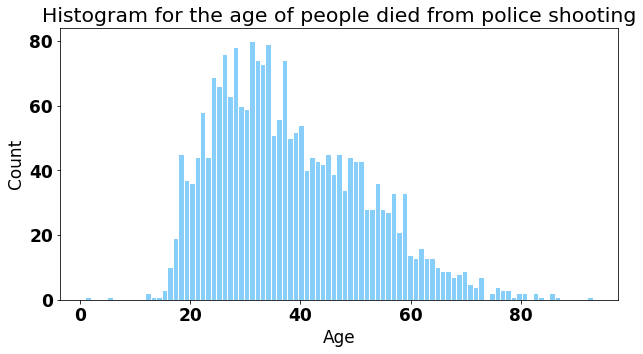

In [78]:
# Plot the histogram for the dependent variable age
matplotlib.rc('figure', figsize=(10, 5))
plt.hist(df_merged_sub["age"], color="lightskyblue", bins=93, edgecolor="white")
plt.ylabel("Count")
plt.xlabel("Age")
plt.title("Histogram for the age of people died from police shooting")
plt.show()

The above graph demonstrates the histogram of people's age when people were shot to death by police officers. The reason I choose this variable is that it is the outcome variable that this study is investigating. Understanding if there is a relationship between death age and people's race is important for the public to protect a certain group of people from racist police shootings. From this histogram, the peak happens around age 30 and the graph is slightly skewed to the right. This means that younger people are more likely to be shot to death than the elders. Also, the number of death increases dramatically from 18 years old to 30 years old. The reason for such a rapid increase could be that younger people are more active and reckless to engage in criminal activities. Thus, when facing the police, they tend to make decisions that threaten police officers' safety, which causes the occurrence of a police shooting.

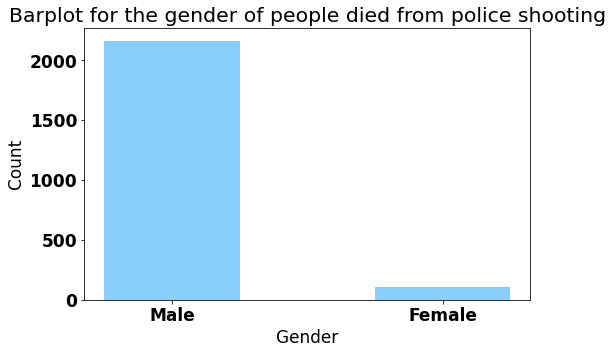

In [79]:
matplotlib.rc('figure', figsize=(8, 5))
# convert float to string in order to clear the x-axis
gender_lst = df_merged_sub["gender"].unique() 
num_male = sum(df_merged_sub["gender"].tolist())
num_female = len(df_merged_sub["gender"].tolist()) - num_male
integer_gender = [str(x) for x in gender_lst]
lst_gender = ["Male", "Female"]
plt.bar(integer_gender, [num_male, num_female], width=0.5, color="lightskyblue", tick_label = lst_gender, align="center")

plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("Barplot for the gender of people died from police shooting")
plt.show()

This figure shows the number of males and females that died from police shootings. This variable is included because it is intuitive to consider that male criminals are more dangerous than female criminals on average. Thus, this intuition could affect whether police choose to pull the trigger or not. In this visualization, it is clear that there is a significant difference between the number of males who were shot to death and the one for females. This difference might be due to that men are more likely to engage in criminal activities and more likely to attack officers when being arrested.

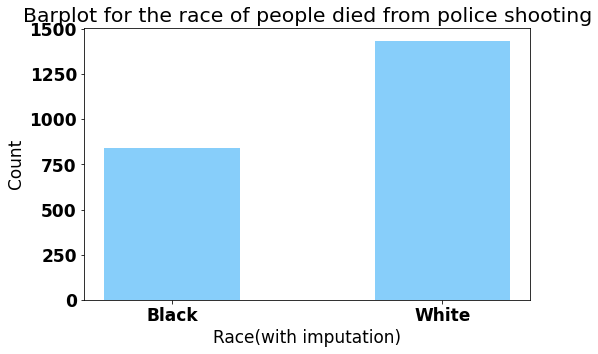

In [80]:
matplotlib.rc('figure', figsize=(8, 5))
race_lst = df_merged_sub["race_imputed"].unique() 
num_black = sum(df_merged_sub["race_imputed"].tolist())
num_white = len(df_merged_sub["race_imputed"].tolist()) - num_black
integer_race = [str(x) for x in race_lst]
plt.bar(integer_race, [num_black, num_white], color="lightskyblue", width=0.5, tick_label = ["Black", "White"])
plt.xlabel("Race(with imputation)")
plt.ylabel("Count")
plt.title("Barplot for the race of people died from police shooting")
plt.show()

This graph shows the difference between the number of White people died from police shooting and the number of Black people died from police shooting. This variable is included because the is the main independent variable in this study. From this graph, there are more White people who died from police shooting than Black people.

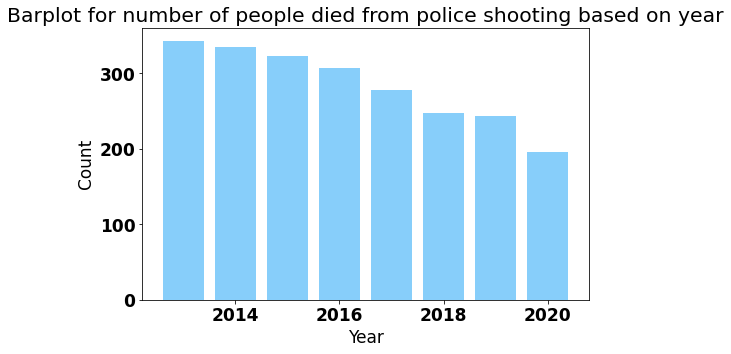

In [81]:
matplotlib.rc('figure', figsize=(8, 5))
plt.bar(df_merged_sub["year"].unique(), df_merged_sub["year"].value_counts().tolist(), color="lightskyblue")
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Barplot for number of people died from police shooting based on year")
plt.show()

This graph shows the trend of number of police shooting cases from 2013 to 2020. This variable is included because it is an important predictor as the society has been more aware of police shooting issue. Thus, there are more and more social pressure to officers and they become more cautious when they protect themselves and stop the criminal. This is exactly the trend this graph illustrated. There is a huge drop from 2019 to 2020. Because in this year, the death of George Floyd triggered a nationwide protest against police violence. The usage of weapon towards people are strongly criticized. Also, the lockdown due to COVID-19 pandemic also played an important role in terms of reducing the number of people died from police shooting. Nevertheless, we can still observe a decreasing trend as year increases.

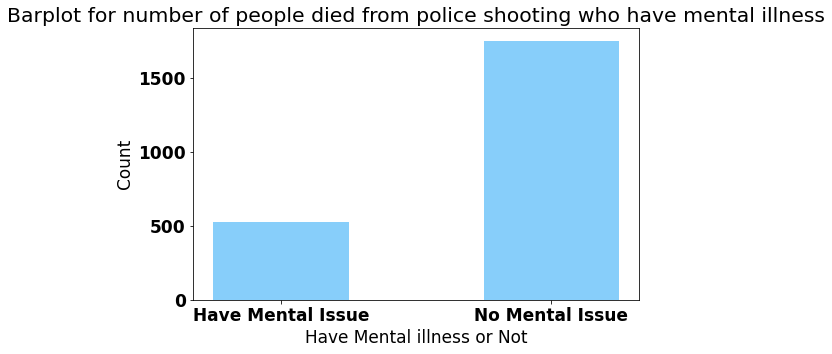

In [82]:
matplotlib.rc('figure', figsize=(8, 5))
lst_mental = df_merged_sub["mental_illness"].unique()
num_mental = sum(df_merged_sub["mental_illness"])
num_normal = len(df_merged_sub["mental_illness"]) - num_mental
int_mental = [str(x) for x in lst_mental]
plt.bar(
    int_mental, [num_mental, num_normal], 
    width=0.5, color="lightskyblue", tick_label = ["Have Mental Issue", "No Mental Issue"])
plt.xlabel("Have Mental illness or Not")
plt.ylabel("Count")
plt.title("Barplot for number of people died from police shooting who have mental illness")
plt.show()

This graph shows the difference between people who have mental issues and died because of police shootings and people who do not have mental illness and died from police shootings. This variable is included because people who are experiencing mental issues act more dangerously. Thus, this is a factor that would influence police to shoot. From this graph, we can see that more people who died from police shootings do not have mental issues. 

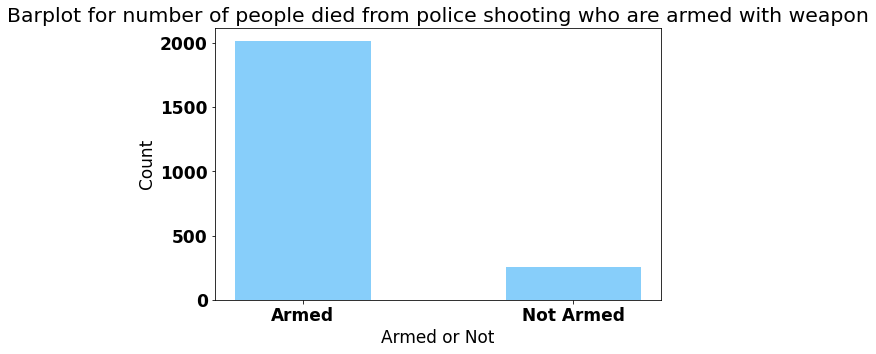

In [83]:
matplotlib.rc('figure', figsize=(8, 5))
lst_arm = df_merged_sub["armed"].unique()
num_arm = sum(df_merged_sub["armed"])
num_noarm = len(df_merged_sub["armed"]) - num_arm
int_arm = [str(x) for x in lst_arm]
plt.bar(int_arm, 
        [num_arm, num_noarm], 
        width=0.5, 
        color="lightskyblue", tick_label=["Armed", "Not Armed"])
plt.xlabel("Armed or Not")
plt.ylabel("Count")
plt.title("Barplot for number of people died from police shooting who are armed with weapon")
plt.show()

The above figure shows the difference between the number of people who carry a weapon when being shot to death by police and the number of people who did not carry any weapon. I include this variable because this is one of the determining factors that would cause police to shoot. This figure demonstrates that people are very likely to be shot to death if they are armed with a weapon than if they do not have any weapon. Carrying a weapon would increase the danger level of a criminal from a police perspective and increase the chance that criminal attacks police, thus police shooting is more possible to happen.

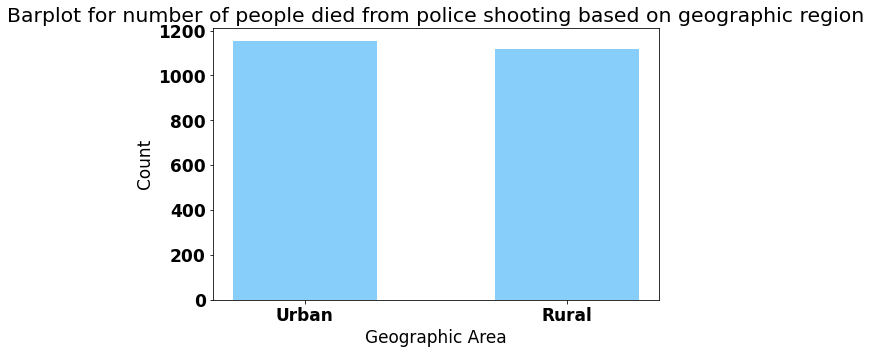

In [84]:
matplotlib.rc('figure', figsize=(8, 5))
lst_geog = df_merged_sub["geographic_area"].unique()
num_urban = sum(df_merged_sub["geographic_area"])
num_rural = len(df_merged_sub["geographic_area"]) - num_urban
int_urban = [str(x) for x in lst_geog]
plt.bar(
    int_urban, 
    [num_urban, num_rural], 
    width=0.55, 
    color="lightskyblue",
    tick_label = ["Urban", "Rural"])

plt.xlabel("Geographic Area")
plt.ylabel("Count")
plt.title("Barplot for number of people died from police shooting based on geographic region")
plt.show()


This plot shows the number of police shootings that cause death in urban areas and rural areas. This is included because the frequency of criminal activities is more likely to be affected by the regions. It is noticeable that police shooting cases are equally likely to take place in the urban area than in the rural area. The number of cases in the urban area approximately equals the total number of cases in the rural area.

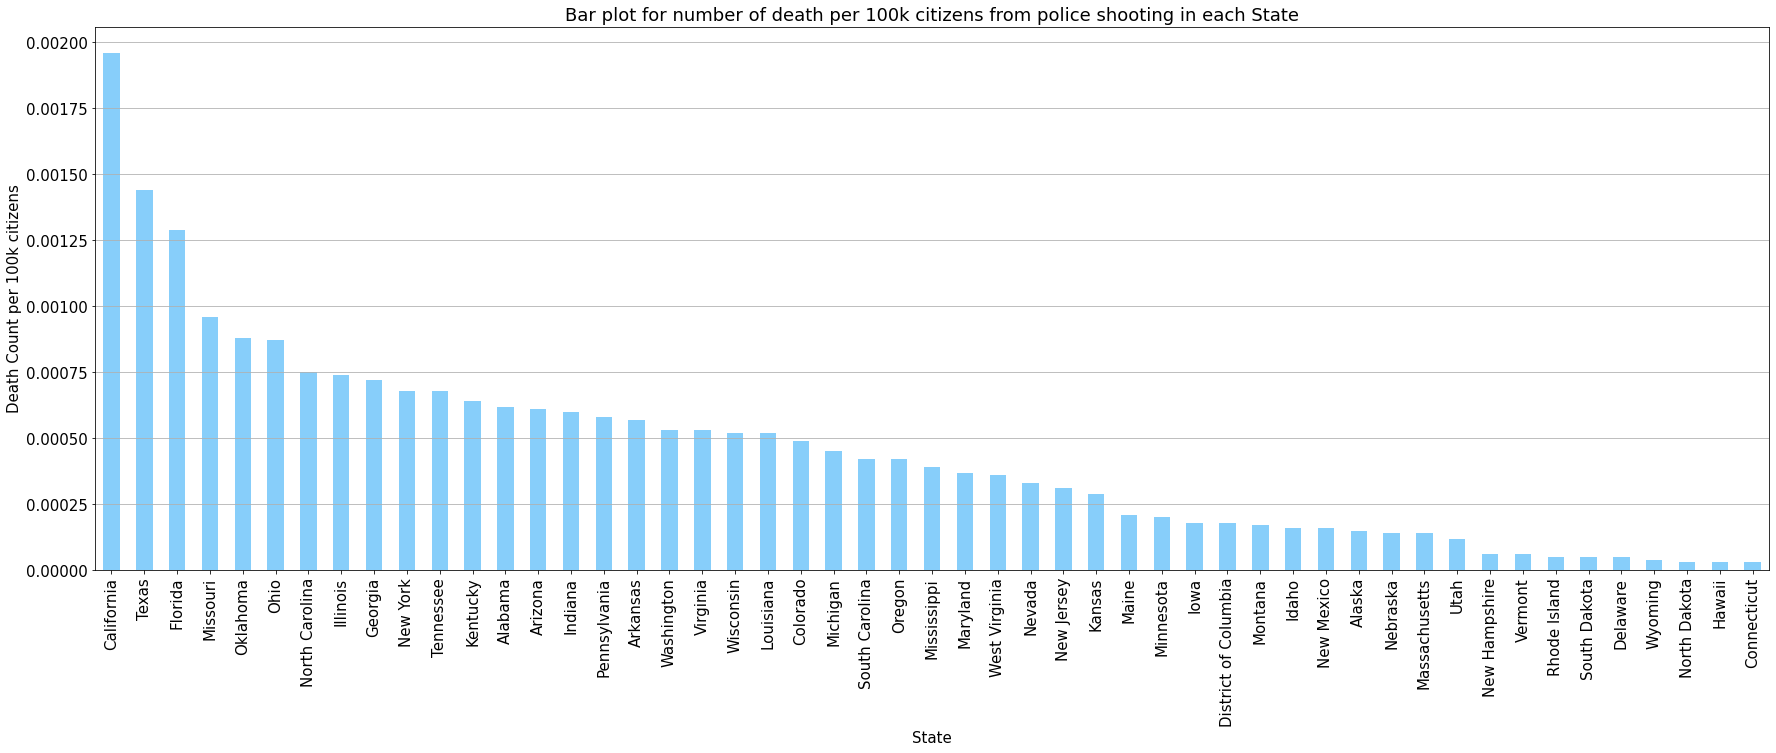

In [85]:
# Barplot for number of people died from police violence in each State
matplotlib.rc('figure', figsize=(30, 10))
font = {'weight' : 'normal',
        'size'   : 15}
matplotlib.rc('font', **font)

# Use groupby to count the shooting occurrence
df_group_state = df_merged_sub.groupby(by="state_code")
df_deathcount = df_group_state.count().iloc[:, 0]
df_deathcount = df_deathcount.to_frame(name="death_count")
df_deathcount.reset_index(level=0, inplace=True)
df_deathcount_merged = df_deathcount.merge(state_code, right_on="Code", left_on="state_code", how="left")
df_deathcount_per100k = []
for idx, row in df_deathcount.iterrows():
    df_deathcount_per100k.append(int(row["death_count"])/100000)
df_deathcount_merged.insert(len(df_deathcount_merged.columns), "death_count_per_100k", df_deathcount_per100k)

df_deathcount_sort = df_deathcount_merged.sort_values(by="death_count_per_100k", ascending=False)
ax = df_deathcount_sort.plot(kind="bar", x="State", y="death_count_per_100k", color="lightskyblue", legend=False)
plt.grid(visible=True, axis="y")
plt.xlabel("State")
plt.ylabel("Death Count per 100k citizens")
plt.title("Bar plot for number of death per 100k citizens from police shooting in each State")
plt.show()

This graph demonstrates the number of death per 100k citizens due to police shootings in each state. I include this variable because I believe that there are differences in criminal activity frequency across states in the US. I divided the death count by 100000 to calculate the death count per 100k citizens so that the difference in population of states is normalized. From this graph, it is clear that California (CA) has the most police shootings that cause deaths per 100k civilian. The second highest police shooting occurrence is in Texas (TX) and the third-highest is Florida (FL). Other states have relatively fewer occurrences of police shootings. The three states that have high police shooting cases might be due to gang activities and conflicts so that police shoot more frequently when arresting criminals.

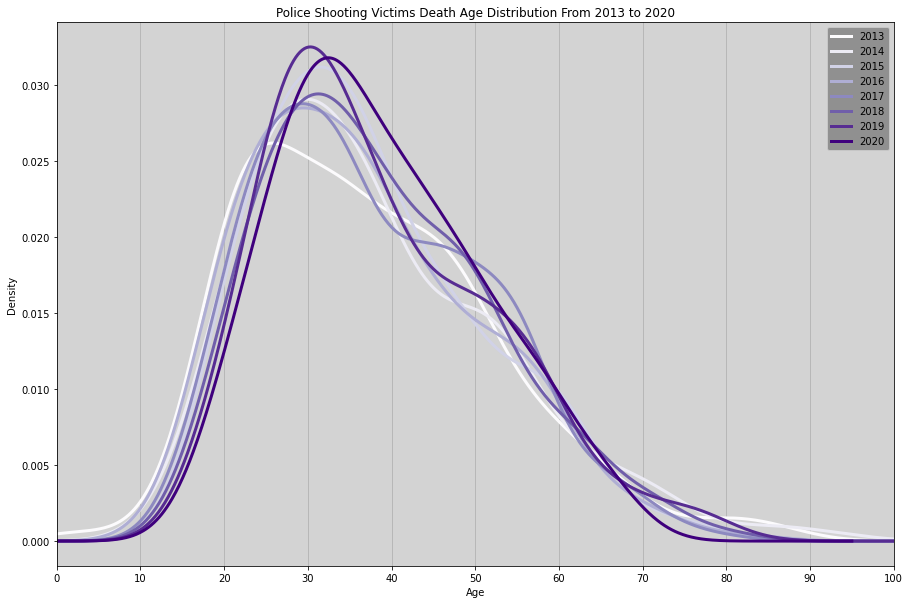

In [86]:
# Use groupby method to get more insights
## For changing the text size
font = {'weight' : 'normal',
        'size'   : 10}
matplotlib.rc('font', **font)
matplotlib.rc('figure', figsize=(15, 10))
plt.rcParams['figure.facecolor'] = 'white'

groupby_state_geo = df_merged_sub.pivot(columns="year", values="age")
groupby_state_geo.plot.density(xlim=[0, 100], linewidth=3, colormap="Purples").patch.set_facecolor('lightgrey')
plt.legend(facecolor="grey")
plt.grid(visible=True, axis="x")
plt.xlabel("Age")
plt.xticks(np.arange(0, 110, 10))
plt.title("Police Shooting Victims Death Age Distribution From 2013 to 2020")
plt.show()


The above series of plots demonstrate the distribution of the death age due to police shootings each year. As the year increases, the mean age of people die due to police shootings increased from 25 to 33. This means that more adults participate in criminal activities and attack the police. Another reason that can explain this trend is that, as police shooting becomes a rising issue and the public pays more attention, more adults at this age period are protesting and more easily to act recklessly to express their anger to the police.

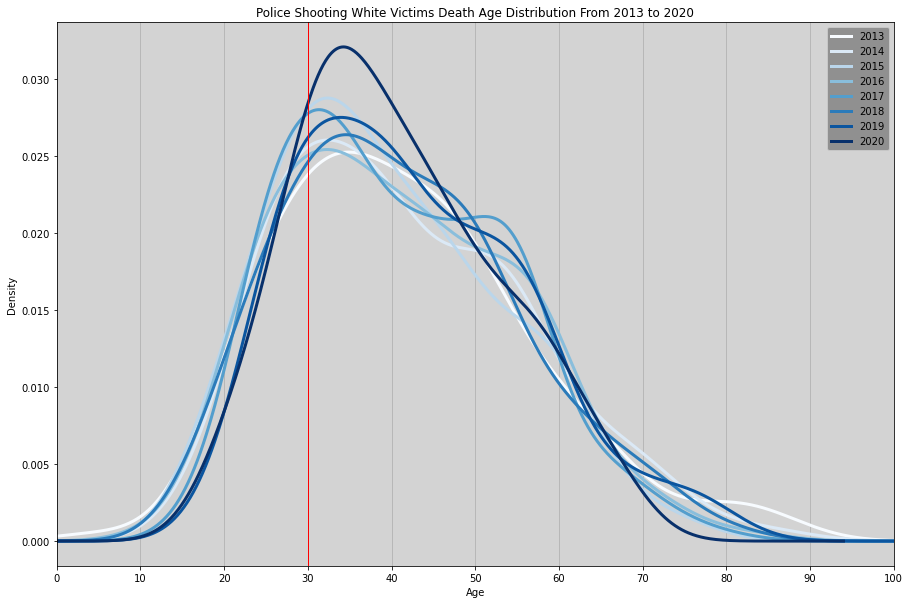

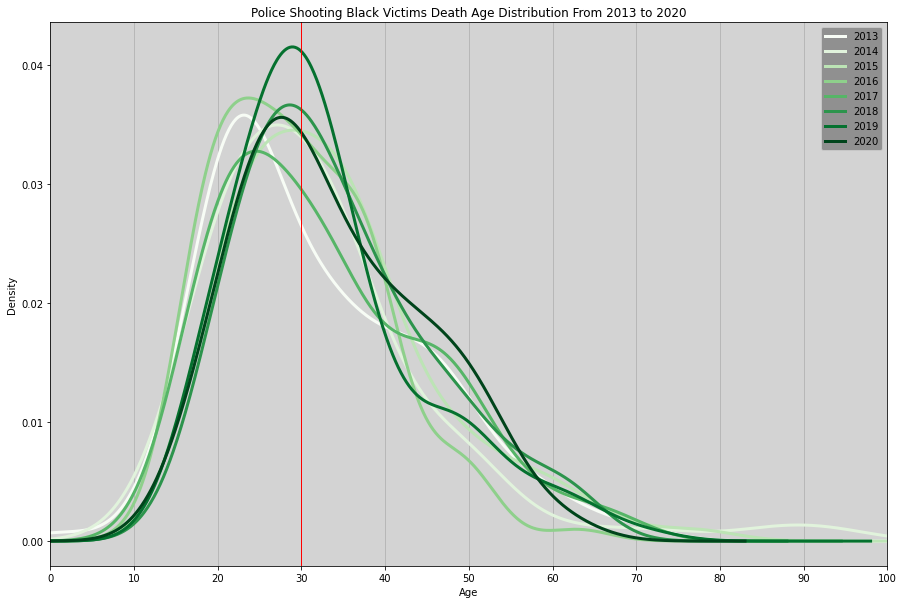

In [87]:
## Groupby Year and race
### For changing text size
font = {'weight' : 'normal',
        'size'   : 10}
matplotlib.rc('font', **font)
# matplotlib.rc('figure', figsize=(10, 5))
plt.rcParams['figure.facecolor'] = 'white'

# select white
df_merged_sub_wht = df_merged_sub[df_merged_sub["race_imputed"] == 0]
df_merged_sub_wht["race_imputed"].replace({0 : "White"}, inplace=True)
# Select black
df_merged_sub_blk = df_merged_sub[df_merged_sub["race_imputed"] == 1]
df_merged_sub_blk["race_imputed"].replace({1 : "Black"}, inplace=True)

groupby_state_geo2 = df_merged_sub_wht.pivot(columns=["year"], values="age")
groupby_state_geo2.plot.density(xlim=[0, 100], linewidth=3, colormap="Blues").patch.set_facecolor('lightgrey')
plt.axvline(x=30, color="red", lw=1)
plt.legend(facecolor="grey")
plt.grid(visible=True, axis="x")
plt.xlabel("Age")
plt.xticks(np.arange(0, 110, 10))
plt.title("Police Shooting White Victims Death Age Distribution From 2013 to 2020")

groupby_state_geo3 = df_merged_sub_blk.pivot(columns=["year"], values="age")
groupby_state_geo3.plot.density(xlim=[0, 100], linewidth=3, colormap="Greens").patch.set_facecolor('lightgrey')
plt.axvline(x=30, color="red", lw=1)
plt.legend(facecolor="grey")
plt.grid(visible=True, axis="x")
plt.xlabel("Age")
plt.xticks(np.arange(0, 110, 10))
plt.title("Police Shooting Black Victims Death Age Distribution From 2013 to 2020")
plt.show()

This pair of plots demonstrates the death age due to police shooting for Black people and White people from 2013 to 2020. When comparing the graphs of Black people, it is clear that the death age for African Americans is younger than the death age for White. This could be the result of the conflict between police and African Americans, especially after the "Black Lives Matter" movement which started in 2013.

# Project 2

## Part 1

I have made changes to all visualizations in project 1 as well as some categorizing conditions. Please see the content above.

# Part 2

## Main Message: Does African Americans die at a younger age than Caucasian Americans?

### Main Message Plot

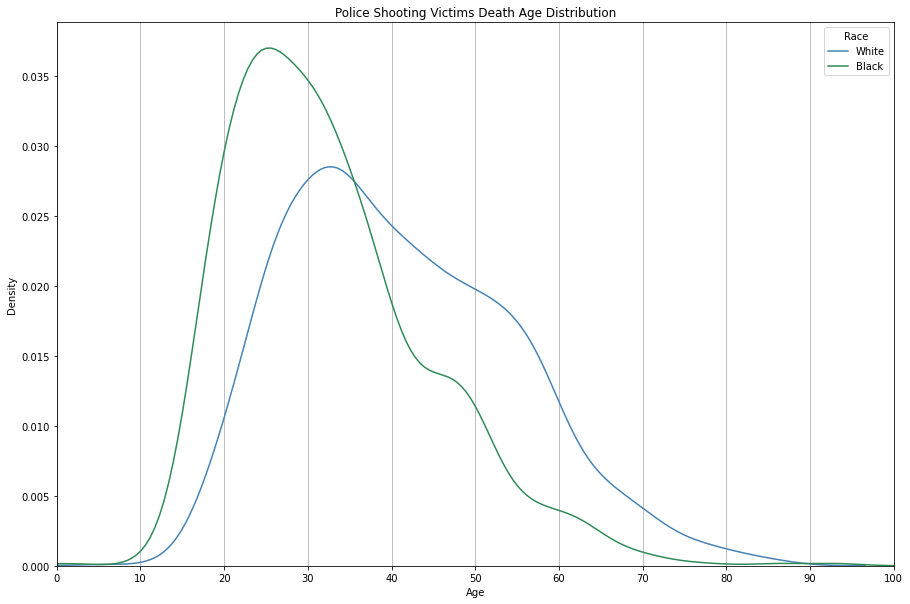

In [88]:
import seaborn as sns
## Groupby Year and race
### For changing text size
font = {'weight' : 'normal',
        'size'   : 10}
matplotlib.rc('font', **font)
matplotlib.rc('figure', figsize=(15, 10))
plt.rcParams['figure.facecolor'] = 'white'

# select white
df_merged_sub_wht = df_merged_sub[df_merged_sub["race_imputed"] == 0]
df_merged_sub_wht["race_imputed"].replace({0 : "White"}, inplace=True)
# Select black
df_merged_sub_blk = df_merged_sub[df_merged_sub["race_imputed"] == 1]
df_merged_sub_blk["race_imputed"].replace({1 : "Black"}, inplace=True)

sns.kdeplot(data=df_merged_sub_wht, x="age", color="steelblue")
sns.kdeplot(data=df_merged_sub_blk, x="age", color="seagreen").set(xlim=(0, 100))
plt.legend(labels = ["White", "Black"], title="Race")
plt.grid(visible=True, axis="x")
plt.xlabel("Age")
plt.xticks(np.arange(0, 110, 10))
plt.title("Police Shooting Victims Death Age Distribution")
plt.show()

### Interpretation:

This graph shows the distribution of the death age of people that are shot to death by police for African Americans and Caucasian Americans since we are investigating if black people's death age is younger than white people's death age. It is clear to see that most African American victims die around the age of 25 whereas most Caucasian American victims die around the age of 32. Also, we can observe that the density at the peak age for black victims is higher than the density at the peak age for white victims. As the data records death cases from 2013 to 2020 and during this period of time the conflict between African American community and police had become more severe, especially after the death of George Floyd, thus these conflicts could be the reason of our observed difference in age.

# Part 3

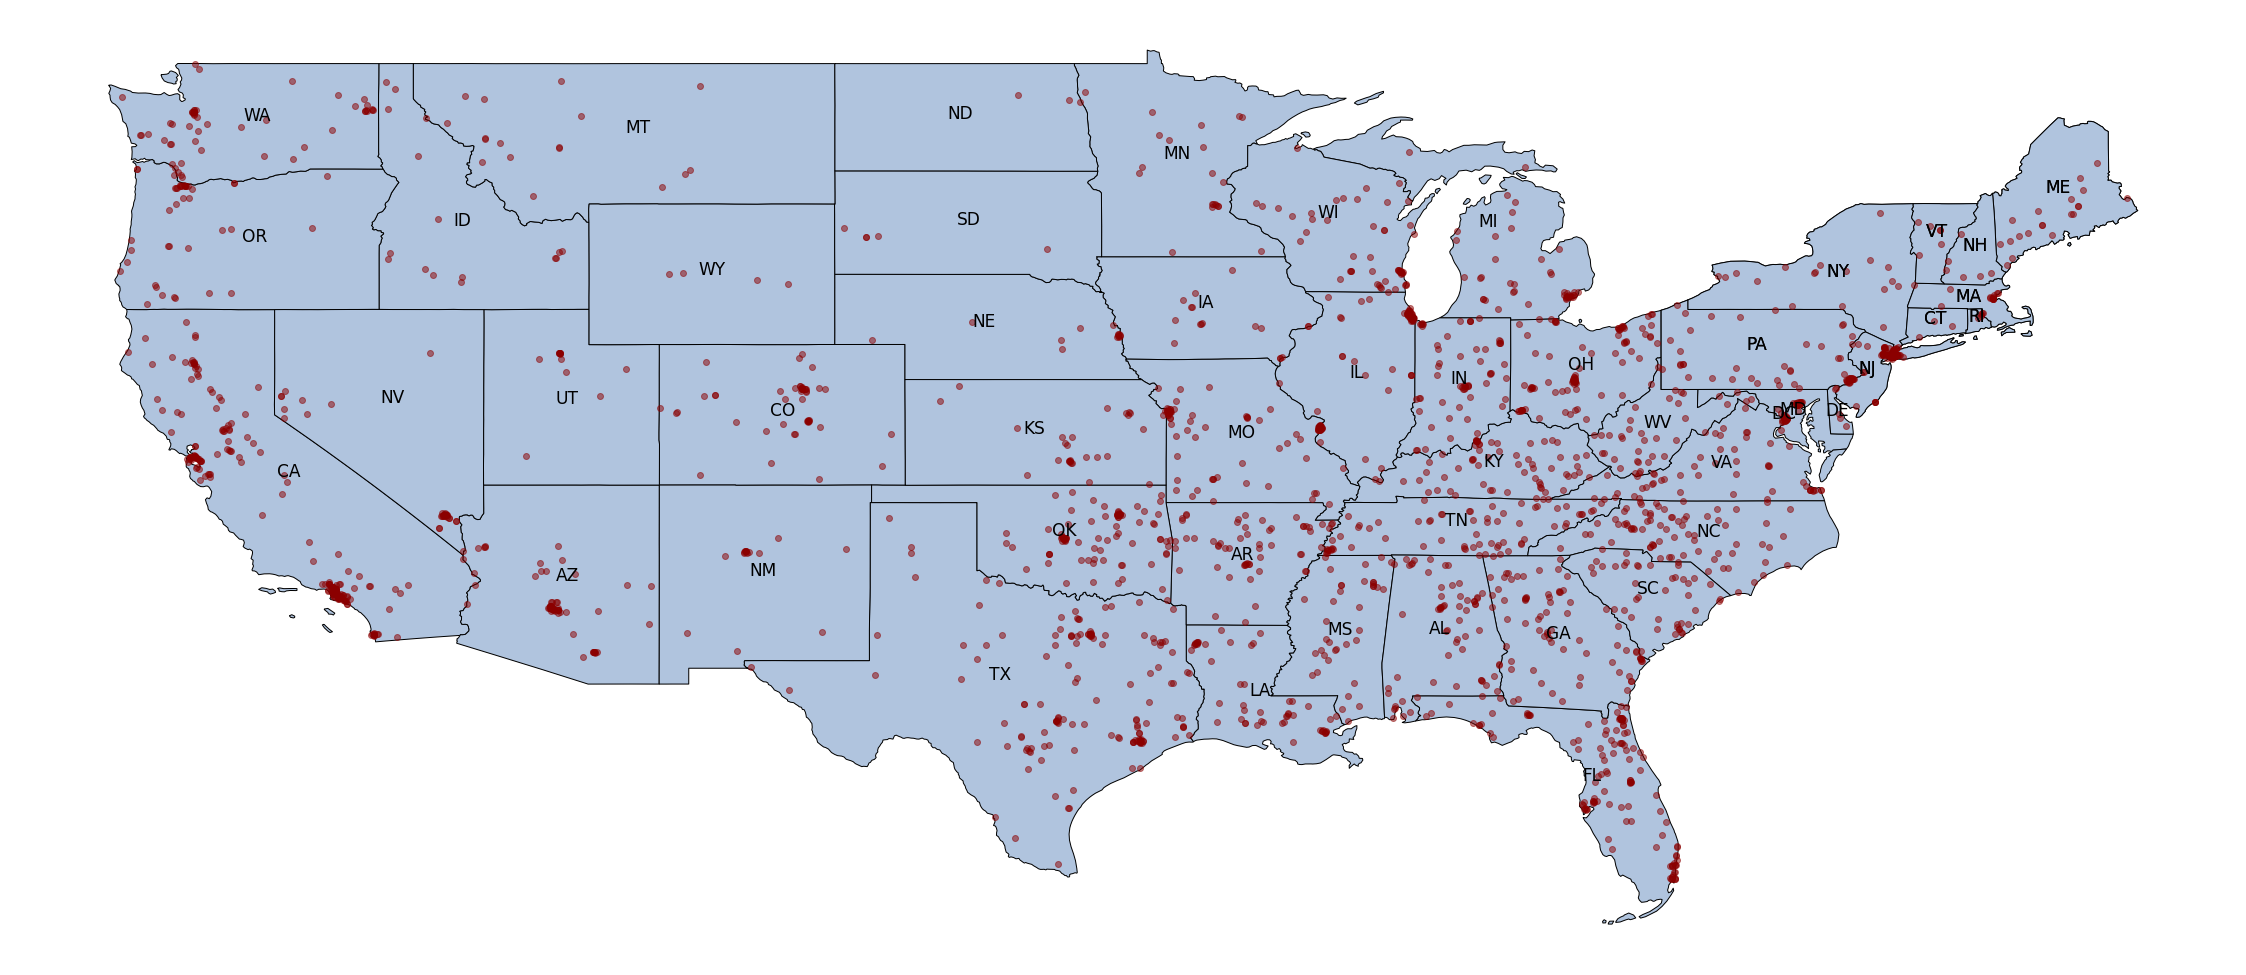

In [89]:
## Plot the number of gunshot in each state in the US
### Plot the map of usa
fig, gax = plt.subplots(figsize=(40,40))
state_df = gpd.read_file('/Users/alex/Desktop/ECO225/ECO225Project/geopandas-tutorial/data/usa-states-census-2014.shp')
state_df.plot(ax=gax, edgecolor="black", color="lightsteelblue")

# Get the coordinate where shooting happen
## Only want mainland usa
df_merged_sub_main = df_merged_sub[df_merged_sub["state_code"] != "AK"]
df_merged_sub_main = df_merged_sub_main[df_merged_sub_main["state_code"] != "HI"]
df_merged_sub_main["Coordinates"] = list(zip(df_merged_sub_main.longitude, df_merged_sub_main.latitude))
df_merged_sub_main["Coordinates"] = df_merged_sub_main["Coordinates"].apply(Point)
gdf_usa = gpd.GeoDataFrame(df_merged_sub_main, geometry="Coordinates")
gdf_usa.plot(ax=gax, color='darkred', alpha = 0.5)
state_df.apply(lambda x: gax.annotate(s=x.STUSPS, xy=x.geometry.centroid.coords[0], ha='center', fontsize=17),axis=1)
plt.axis("off")
plt.show()

This map shows the distribution of the locations of police shooting. Each red dot represents an occurrence of police shooting. From this graph, it is obvious that most shootings happen in the middle east or east part of the US and the west coast. Points are sparse for states that are in the middle of the US. 

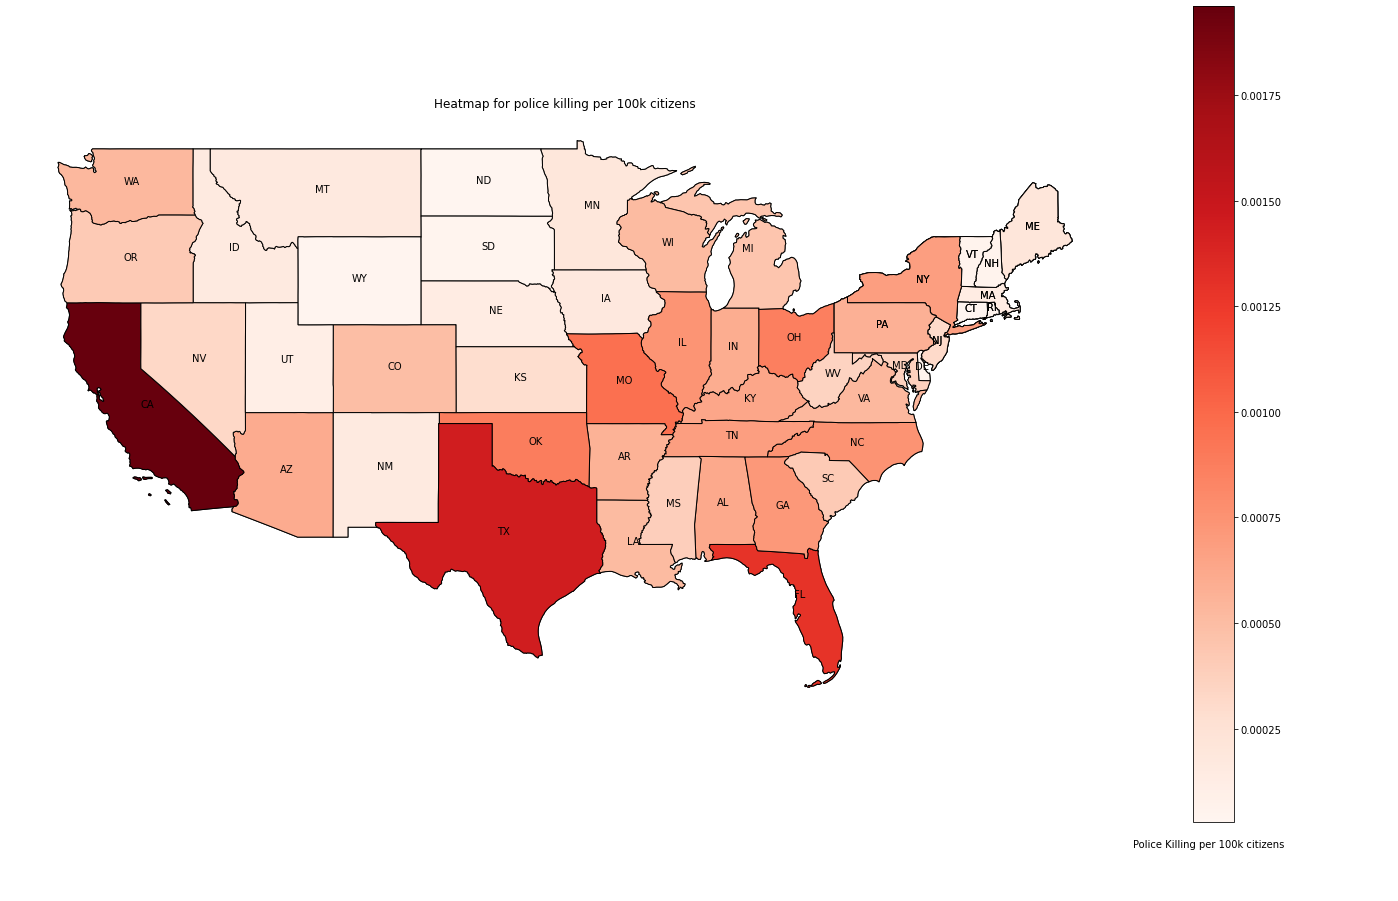

In [90]:
# Plot the heat map
## Get the number of gunshot per square kilometer
gb_state = df_merged_sub_main.groupby("state")
df_count = gb_state.count().iloc[:, 0]
df_count = df_count.to_frame(name="count")
df_count.reset_index(level=0, inplace=True)
### Merge state with its full name dataset
df_count_merged = df_count.merge(state_code, right_on="Code", left_on="state", how="left")
### Remove Washington DC
df_count_merged = df_count_merged[df_count_merged["state"] != "DC"]
### Insert a column that calculate the death per 100k citizens
df_count_per100k = []
for idx, row in df_count_merged.iterrows():
    df_count_per100k.append(int(row["count"])/100000)
df_count_merged.insert(len(df_count_merged.columns), "death_per_100k", df_count_per100k)


## plot the heat map
fig, gax = plt.subplots(figsize=(25,15))
state_df = gpd.read_file('/Users/alex/Desktop/ECO225/ECO225Project/geopandas-tutorial/data/usa-states-census-2014.shp')
state_df.plot(ax=gax, edgecolor="black", color="white")
df_count_merged_final = df_count_merged.merge(state_df, left_on="State", right_on="NAME", how="left")
df_count_merged_final = gpd.GeoDataFrame(df_count_merged_final)
df_count_merged_final.apply(lambda x: gax.annotate(s=x.STUSPS, xy=x.geometry.centroid.coords[0], ha='center', fontsize=10),axis=1)
df_count_merged_final.plot(ax=gax, edgecolor="black", column='death_per_100k', legend=True, cmap='Reds', vmin=df_count_merged_final["death_per_100k"].min(), 
    vmax=df_count_merged_final["death_per_100k"].max())
gax.annotate('Police Killing per 100k citizens',xy=(0.81, 0.06),  xycoords='figure fraction')
plt.axis('off')
plt.title("Heatmap for police killing per 100k citizens")
plt.show()


This is a heat map for the count of police killing cases. I merged the my own dataset with the US states census data in order to create a geographic dataframe. From the previous map, we concluded that the middle-east and coastal part of the US have most frequent police killing cases. In this heatmap, we can also observe the same pattern as the color of these states is more solid than other states, for example, states in the middle north area, indicating higher death rate per 100k citizens. Another pattern that is obvious to observe through the heatmap is that California has the highest death count per 100k citizens and Texas is the second and lastly Florida is the third highest. This observation matches the result that we saw in the Bar plot for number of death per 100k citizens in each state. One potential reason that can explain this pattern is gang activities. Especially for California and Florida, the underground gang activities are strongly associated with popular hip-hop music culture.

In [91]:
df_merged_sub_main = df_merged_sub[df_merged_sub["state_code"] != "AK"]
df_merged_sub_main = df_merged_sub_main[df_merged_sub_main["state_code"] != "HI"]
df_merged_sub_main = df_merged_sub_main.merge(state_code, right_on="Code", left_on="state_code", how="left")
df_merged_sub_main = df_merged_sub_main.merge(state_area_in_km2, on="State")

In [92]:
# use html-based web scraping
import requests
from bs4 import BeautifulSoup

loc_url = "https://www.latlong.net/category/states-236-14.html"
response = requests.get(loc_url)
soup_object = BeautifulSoup(response.content)
data_table = soup_object.find_all('table')[0]
all_values = data_table.find_all('tr')

longi_lat = pd.DataFrame(columns=["State", "Latitude", "Longitude"])
idx = 0
for row in all_values[1:]:
    values = row.find_all('td') # Extract all elements with tag <td>
    # Pick only the text part from the <td> tag
    state_name = values[0].text
    lat = values[1].text
    long = values[2].text
    longi_lat.loc[idx] = [state_name, lat, long] # Store it in the dataframe as a row
    idx += 1

# First, only keep state name. Currently: eg. Vermont, USA  To: eg. Vermont
def remove_usa(input):
    return input[:input.find(",")]
longi_lat["State"] = longi_lat["State"].apply(remove_usa)

# now merge with the dataset that contains the population for each state.
state_pop = state_area_in_km2.loc[:, ["State", "Pop"]]
longi_lat_pop = longi_lat.merge(state_pop, on="State", how="right")
# remove hawaii and alaska since we only focus on the mainland of US
longi_lat_pop = longi_lat_pop[longi_lat_pop["State"] != "Alaska"]
longi_lat_pop = longi_lat_pop[longi_lat_pop["State"] != "Hawaii"]
longi_lat_pop

,State,Latitude,Longitude,Pop
1,Texas,31.000000,-100.000000,30097526
2,California,36.778259,-119.417931,39664128
3,Montana,46.965260,-109.533691,1093117
4,New Mexico,34.307144,-106.018066,2109093
5,Arizona,34.048927,-111.093735,7640796
6,Nevada,39.876019,-117.224121,3238601
7,Colorado,39.113014,-105.358887,5961083
8,Oregon,44.000000,-120.500000,4325290
9,Wyoming,43.075970,-107.290283,582233
10,Michigan,44.182205,-84.506836,9995212


In [93]:
import folium

map = folium.Map(width=2000,height=900,location=[35, -90], zoom_start=4.5)
for i in range(len(longi_lat_pop)):
    folium.Circle(
      location=[longi_lat_pop.iloc[i]['Latitude'], longi_lat_pop.iloc[i]['Longitude']],
      radius=float(longi_lat_pop.iloc[i]['Pop'])/200,
      color='crimson', fill=True,
      fill_color='crimson').add_to(map)
map

This map is added to demonstrate the size of each state in the US. From previous heat map, we observed patterns that states that locate in middle-east part of the US and a few coastal states such as California, Florida, and Texas have higher police killing cases per 100k citizens. As this map shows the population size of each state in terms of the size of the circle, we can see that the most of the states I just mentioned have relatively large population size. Thus, we can see the correlation that the larger the state's population the higher the number of police killing cases.

In order to produce this map, I used HTML-based web scraping for the state name, state latitude, and state longitude. Then I merged this scraped dataset with the dataset that contains population size based on the state name. Then I used folium map for visualization.

# Project 3

## Part 1

I have made changes according to the feedback from project 2. I add a new map with newly learned technique HTML-based Web Scraping.

## Part 2

1. 
(a). I would like to add some criminal arrests records for drugs to my project. When talking about criminal activities, one of the most common words that people can think of is illegal drug sales. Also, selling drugs often are associated with guns. Thus, when police is going to arrest criminals, it is very likely that criminals will use guns and fatal police shooting will occur. Hence, I believe it is reasonable to include drug arrest records in the analysis. 

(b). I will use HTML-based web scraping through this website: https://ucr.fbi.gov/crime-in-the-u.s/2018/crime-in-the-u.s.-2018/tables/table-69 . This website records all arrests for each states in 2018. Unfortunately, the website does not provide data for any other years from 2013 to 2020. However, since 2018 is in the middle of 2013 and 2020, I believe that it would provide useful insights as well.

(c) After scraping down the data, I would like to merge it with the data I used to generate heat map. I would like to demonstrate the number of drug arrests in each states so that we can visually observe any association between drug activities and police killing cases.

2. Since the website only provides data for 2018, I do not need to run the scraping program repeatedly. By inspecting the html file for the website, I found that the table is available for public access, thus I can scrape the data from the website. One thing I found it difficult at first is that I only want to scrape the columns that I am interested in and it is hard to locate the HTML code for those particular columns. Thus, I searched on Google and learned that the BeautifulSoup has a select function to extract the column I want.

3. Scraping Data

In [94]:
drug_url = "https://ucr.fbi.gov/crime-in-the-u.s/2018/crime-in-the-u.s.-2018/tables/table-69"
response = requests.get(drug_url)
soup_object = BeautifulSoup(response.content, "html.parser")

Here, I store the URL that contains the table I would like to scrape. Then, I use the GET function in the request package to get the response for my GET request to the URL. Use BeautifulSoup function to parse the contents in the websites.

In [95]:
# Here I extract the Drug Arrest column
drug_lst = []
for td in soup_object.select("table.data tr td:nth-child(22)"):
    drug_lst.append(td.text.strip())
drug_lst_correct = []
i = 0
while i < len(drug_lst):
    if i%2 != 0:
        drug_lst_correct.append(drug_lst[i])
    i += 1

Since there are too many columns that I do not need in the original table, I use the select function to get each value from the column that I am interested in. I put those values in a list. In that column, I only interested in total value while there are other values as well. Hence, I use a while loop to extract only the value I would like to use in my analysis.

In [96]:
# Here I extract State Name Column
state_lst = []
for td in soup_object.select("table.data tr th:nth-child(1)"):
    state_lst.append(td.text.strip())
state_lst_correct = []
i = 0
while i < len(state_lst):
    if i%2 != 0:
        state_lst_correct.append(state_lst[i])
    i += 1

The situation is similar to the last step for extracting the state name, thus I use loops here.

In [97]:

columnbia_idx = state_lst_correct.index('DISTRICT OF COLUMBIA5')
state_lst_correct.remove('DISTRICT OF COLUMBIA5')
drug_lst_correct.pop(columnbia_idx)

for i in range(len(state_lst_correct)):
    # no digit, no space
    if state_lst_correct[i].isalpha():
        continue
    else:
        # have digits
        first_num_index = 0
        num_index_lst = re.findall('[0-9]', state_lst_correct[i])
        if len(num_index_lst) != 0:
            first_num_index = state_lst_correct[i].index(num_index_lst[0])
            state_lst_correct[i] = state_lst_correct[i][:first_num_index]


After extracting the state names, I remove the observation for District of Columbia and its drug arrest value since it is out of the scope of my analysis. Then, I iterate over each state name and extract only English characters and space and use Regex for making decisions.

In [98]:
drug_state = pd.DataFrame(columns=["State", "Drug Arrest"])
drug_state["State"] = state_lst_correct
drug_state["Drug Arrest"] = drug_lst_correct
drug_state

,State,Drug Arrest
0,ALABAMA,"8,217"
1,ALASKA,"1,046"
2,ARIZONA,"32,272"
3,ARKANSAS,"17,954"
4,CALIFORNIA,"219,251"
5,COLORADO,"16,172"
6,CONNECTICUT,"8,087"
7,DELAWARE,"3,707"
8,FLORIDA,"134,142"
9,GEORGIA,"37,291"


Lastly, I put the corrected state name and the number of drug arrests into a dataframe. By examing the dataframe, we see that the number of drug arrest for Iowa is missing. Unfortunately, the website did not specify the reason of recording this missing value.

4. Merge the scraped data with original data

In [99]:
# First, make state name lower-cased except the first letter
drug_state["State"] = drug_state["State"].apply(str.title)
# Second, make values in Drug Arrest integer from string
def remove_comma_int(input_str):
    if input_str == "":
        return 0
    else:
        if input_str.find(",") == -1:
            return int(input_str)
        new_str = input_str[:input_str.index(",")] + input_str[input_str.index(",")+1:]
        return int(new_str)
drug_state["Drug Arrest"] = drug_state["Drug Arrest"].apply(remove_comma_int)

# Then, join with the longi_lat_pop
drug_longlat_merged = longi_lat_pop.merge(drug_state, on="State", how="left")
drug_longlat_merged

,State,Latitude,Longitude,Pop,Drug Arrest
0,Texas,31.000000,-100.000000,30097526,139188
1,California,36.778259,-119.417931,39664128,219251
2,Montana,46.965260,-109.533691,1093117,2732
3,New Mexico,34.307144,-106.018066,2109093,5375
4,Arizona,34.048927,-111.093735,7640796,32272
5,Nevada,39.876019,-117.224121,3238601,11238
6,Colorado,39.113014,-105.358887,5961083,16172
7,Oregon,44.000000,-120.500000,4325290,13605
8,Wyoming,43.075970,-107.290283,582233,4895
9,Michigan,44.182205,-84.506836,9995212,30320


5. Visualization

In [100]:
for i in range(len(drug_longlat_merged)):
    folium.Circle(
      location=[float(drug_longlat_merged.iloc[i]['Latitude'])+0.5, float(drug_longlat_merged.iloc[i]['Longitude'])],
      radius=float(drug_longlat_merged.iloc[i]['Drug Arrest']),
      color='purple', fill=True,
      fill_color='purple').add_to(map)
map

<Figure size 720x1152 with 0 Axes>

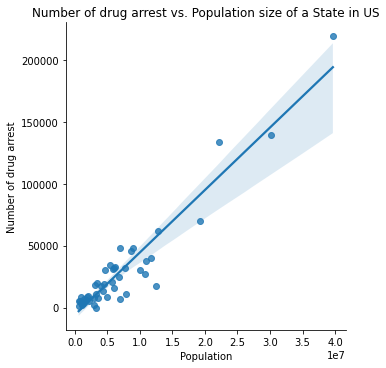

In [101]:
figure(figsize=(10, 16))
sns.lmplot(x="Pop", y="Drug Arrest", data=drug_longlat_merged)
plt.title("Number of drug arrest vs. Population size of a State in US")
plt.xlabel("Population")
plt.ylabel("Number of drug arrest")
plt.show()

I added the number of drug arrest for each state to the previous folium map using the purple circles and the size of the purple circle reflects the magnitude of drug arrests. However, one thing to keep in mind is that it is meaningless to compare the size of red circle to purple circle as the radius was calculated by different methods.

From this graph, we can see that there is a positive relationship between the population size of a state and the number of drug arrests. This relationship is also proven by the scatter plot below which shows that there is a positive correlation between them. Moreover, similar pattern is demonstrated compared with previous heat map, that most states in middle-east part of US have more drug arrests than the states in the middle area of US and California, Texas, and Florida are the top 3 states that have the highest drug arrest cases. The reasons behind the positive relationship between population size and drug arrests are that firstly there are higher probabilities of people dealing with drugs and get caught by the police due to larger population, and secondly drug dealers are more likely to sell their drugs in larger cities as there will be more "customers".

# Final Project

## Part 1

I have refined my introduction by adding more literature reviews and explanation of how my study differs from the existing literature.

## Part 2

I have made changes to my third project by incorporating the comments and added necessary plots and features of visualizations.

## Part 3: OLS regression

### Method

In this study, a set of linear regression analysis is conducted. I choose to use linear regression is firstly because my outcome variable (age) is an continuous variable and secondly I believe that the effects of my predictors are linear to age because from existing literature researchers have been using linear regressions to analyze the relationship. All the variables I use to fit linear regressions are listed below.

- Outcome variable
    - Age: the death age of the suspect who is being shot to death by police

- Independent Variables
    - Race: the race of the suspect, a binary variable that 0 represents white and 1 represents black;
    - Gender: the gender of the suspect, a binary variable that 0 represents female and 1 represents male;
    - Mental illness: whether suspect has mental illness, a binary variable that 1 represents suspect has mental illness otherwise 0;
    - Armed: whether suspect is armed with weapon, a binary variable that 1 represents armed 0 otherwise;
    - Geographic region: the geographic region in which the police shooting takes place, a binary variable that 1 represents urban and 0 represents rural;

Since race is the main independent variable that this study is interested in, it needs to be in the model. I believe that gender is also an important factor since male suspects in general would cause more threats than women suspects. Mental illness is also included because a suspect with mental health issue would be more dangerous as he/she might not be conscious enough to behave rationally and then police needs to use force to arrest him/her. This would cause higher chance of police killing. Next, suspects who are armed with weapon can be a crucial factor that influence police's decision since the threats from suspects are magnified, thus I included it as one of the predictors. Lastly, I included the geographic region variable since from previous analysis that population size has a positive effect of police shooting and urban area usually has larger population than rural area. Hence geographic region would influence the police killing to some extents.

In order to get unbiased estimates of the effects of each predictors, four linear regression model assumptions needs to be satisfied:

- Age is related to the coefficients of predictors in a linear relationship.
- Error is uncorrelated.
- Error variance is constant (homoskedasticity).
- Error follows a Nomral distribution.

I would like to fit 6 models.
- $age = \beta_0 + \beta_1\text{race} + \mu$
- $age = \beta_0 + \beta_1\text{race} + \beta_2\text{gender} + \beta_3\text{mental illness} + \beta_4\text{armed} + \beta_5\text{geographic region} + \mu$
- $age = \beta_0 + \beta_1\text{race} + \beta_2\text{gender} + \beta_3\text{mental illness} + \beta_4\text{armed} + \beta_5\text{geographic region} + \beta_6\text{race}:\text{gender} + \mu$
- $age = \beta_0 + \beta_1\text{race} + \beta_2\text{mental illness} + \beta_3\text{armed}  + \beta_4\text{mental illness}:\text{armed} + \mu$
- $age = \beta_0 + \beta_1\text{race} + \beta_2\text{gender} + \beta_3\text{geographic region} + \mu$
- $age = \beta_0 + \beta_1\text{race} + \beta_2\text{gender} + \mu$

In all of the 6 model specifications, $\beta_0$ is the intercept of the linear trend on the y-axis. other $\beta$s are the effect of the corresponding variable on the death age when holding everything else constant. Lastly, the $\mu$ in each model represents the random error.

For the first simple linear regression model, I only use the race variable as the predictor since it can directly model the effects of race to the death age. However, this simple model suffers from huge biases as it may omit other important variables that can explain the outcome variable.

For the second model, I include all the predictors because it is the model that can capture all the effects of all variables that potentially can explain the death age.

For the third model, I added an interaction term between race and gender as I suspect that there might be a significant effect of some combination of race and gender on the death age.

For the fourth model, I include the race, mental illness, armed and an interaction between mental illness and armed because I suspect that there might be a significant effect of having mental illness and weapon on the death age.

For the fifth model, I include the race, gender, and geographic region because I would like to examine if gender and geographic region can explain the difference in death age well.

For the last model, I only include the race and gender because I am wondering if race and gender are good enough to explain the death age.

### Results

In [102]:
df_merged_sub_lm = df_merged_sub.copy()
x2 = ["race_imputed", "gender", "mental_illness", "armed", "geographic_area"]
reg1 = smf.ols(formula='age ~ race_imputed', data=df_merged_sub_lm).fit()
reg2 = smf.ols(formula='age ~ race_imputed + gender + mental_illness + armed + geographic_area', data=df_merged_sub_lm).fit()
reg3 = smf.ols(formula='age ~ race_imputed + gender + mental_illness + armed + geographic_area + race_imputed:gender', data=df_merged_sub_lm).fit()
reg4 = smf.ols(formula='age ~ race_imputed + mental_illness + armed + armed:mental_illness', data=df_merged_sub_lm).fit()
reg5 = smf.ols(formula='age ~ race_imputed + gender + geographic_area', data=df_merged_sub_lm).fit()
reg6 = smf.ols(formula='age ~ race_imputed + gender', data=df_merged_sub_lm).fit()

info_dict = {
    "F-Statistic": lambda x: f"{x.fvalue:.2f}",
    "AIC": lambda x: f"{x.aic:.2f}",
    "BIC": lambda x: f"{x.bic:.2f}",
    "No. observations": lambda x: f"{int(x.nobs):d}"}

results_table = summary_col(
    results = [reg1, reg6, reg5, reg2, reg4, reg3],
    float_format='%0.2f',
    stars = True,
    model_names=["Model 1", "Model 6", "Model 5", "Model 2", "Model 4", "Model 3"],
    info_dict=info_dict,
    regressor_order = ['Intercept', "race_imputed", "gender", "mental_illness", "armed", "geographic_area"])

print(results_table)


                     Model 1  Model 6  Model 5  Model 2  Model 4   Model 3 
---------------------------------------------------------------------------
Intercept            41.12*** 42.58*** 43.76*** 40.36*** 37.70*** 37.63*** 
                     (0.34)   (1.25)   (1.27)   (1.44)   (0.97)   (1.62)   
race_imputed         -8.47*** -8.44*** -6.90*** -6.23*** -7.82*** 3.53     
                     (0.57)   (0.57)   (0.64)   (0.64)   (0.57)   (2.76)   
gender                        -1.54    -1.67    -1.89             0.91     
                              (1.28)   (1.27)   (1.26)            (1.48)   
mental_illness                                  3.41***  2.46     3.33***  
                                                (0.65)   (1.90)   (0.65)   
armed                                           2.92***  2.72***  3.03***  
                                                (0.86)   (0.98)   (0.86)   
geographic_area                        -3.21*** -3.22***          -3.21*** 
           

From the above result table, we can see the estimates of coefficients for each model. To decide the best model, models are selected based on Adjusted R-squared, AIC, and BIC and we want to select a model that has highest adjusted R-squared while having the smallest AIC and BIC. The adjusted R-squared is a way to quantify how much variation the model predictors can explain while penalizing having large set of predictors. AIC and BIC are criteria that penalize having many predictors in the model. The adjusted R-squared of Model 3 is 0.12 and is slightly larger than the ones of other models. The AIC and BIC of model 3 are 18056.29 and 18096.40 respectively which are smaller than the ones of other models. Hence, Model 3 is strongly preferred.

Thus, the final model is 
- $age = 37.63 +3.53(\text{race}) +0.91(\text{gender}) + 3.33(\text{mental illness}) + 3.03(\text{armed}) -3.21(\text{geographic region}) -10.19(\text{race}:\text{gender})$

From the final model, we can conclude the following things:
- the average death age of a white female suspect who has no mental illness and not armed in rural area is 37.63
- when holding everything else constant, being a black suspect would die around 3.53 years later than a white suspect
- when holding everything else constant, being a male suspect would die around 0.91 years later than a female suspect
- when holding everything else constant, a suspect having mental illness would die around 3.33 years later than a suspect that has no mental illness
- when holding everything else constant, a suspect who is armed would die around 3.03 years later than a suspect who is not armed
- when holding everything else constant, a suspect who is in urban area would die around -3.21 years earlier than a suspect who is in rural area
- when holding mental illness, armed, and geographic region constant, a black male suspect would die around 10.19 years earlier than a white female suspect.

However, it is important to keep in mind that the estimated coefficients for race and gender are not statistically significant, thus it has less meaning. From this model, we can observe some findings that are aligned with previous analysis. For example, suspects die at a younger age in urban area than rural area from police violence and this is consistent with the findings in state-level analysis. On the other hand, it is surprising to see that having mental illness or suspects are armed with weapon would in fact delay the death age of police killing. Lastly, one important finding is that if keep everything else constant then a suspect who is male and black would die around 10.19 years earlier than a white female suspect. The reason why it is important is that there exists a significant effect of the combination of race and gender on the death age. This finding is intuitive because in daily life Male African Americans have severer conflicts with police and suffer from steorotype issue. From the result of regression model, we understood the relationship between death age and being a male african americans better.

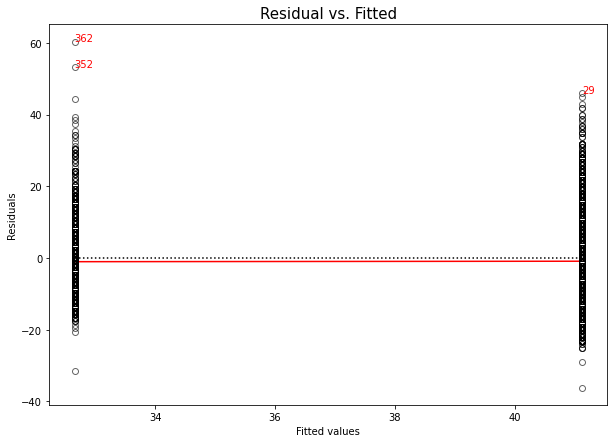

In [103]:
# Residual plot for all six models to assess assumptions
plt.figure(figsize=(10,7))
lmdiag.resid_fit(reg1)
plt.show()

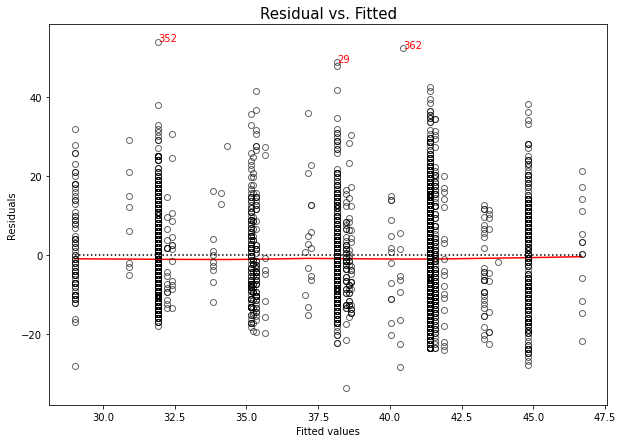

In [104]:
plt.figure(figsize=(10,7))
lmdiag.resid_fit(reg2)
plt.show()

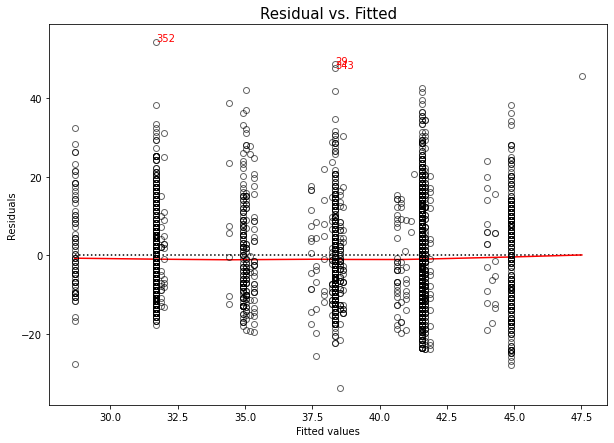

In [105]:
plt.figure(figsize=(10,7))
lmdiag.resid_fit(reg3)
plt.show()

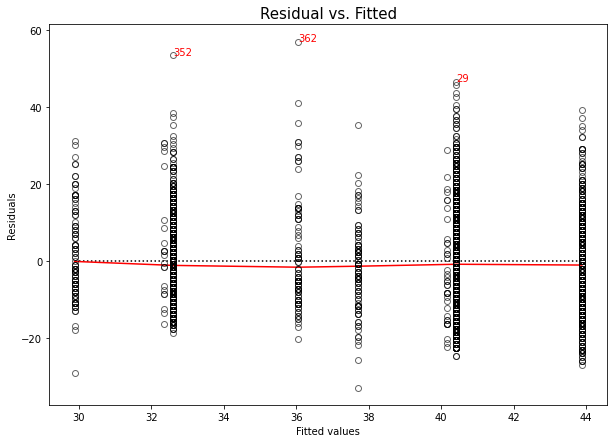

In [106]:
plt.figure(figsize=(10,7))
lmdiag.resid_fit(reg4)
plt.show()

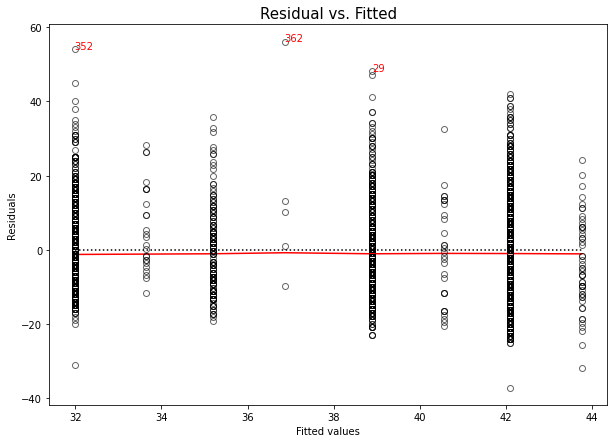

In [107]:
plt.figure(figsize=(10,7))
lmdiag.resid_fit(reg5)
plt.show()

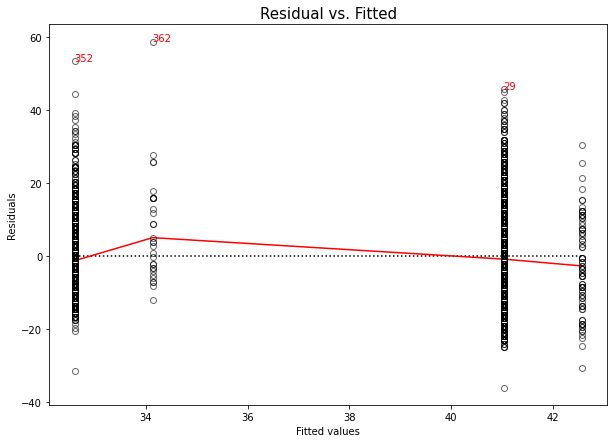

In [108]:
plt.figure(figsize=(10,7))
lmdiag.resid_fit(reg6)
plt.show()

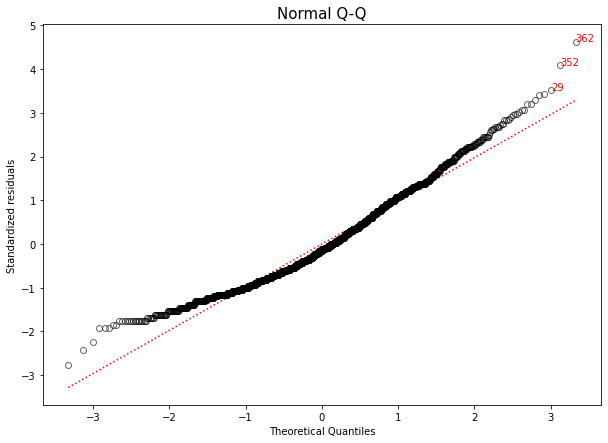

In [109]:
# QQ-plot for all six models to assess normality assumption
plt.figure(figsize=(10,7))
lmdiag.q_q(reg1)
plt.show()

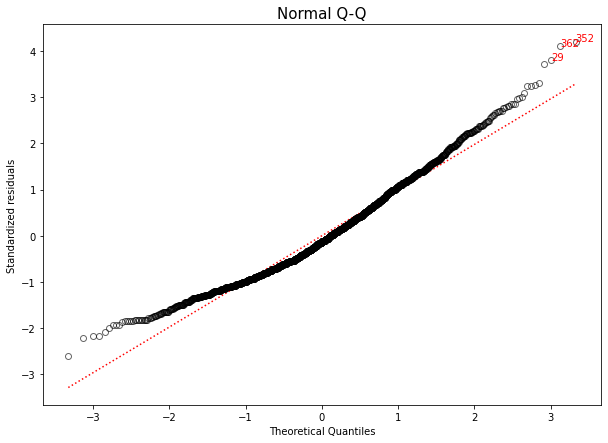

In [110]:
plt.figure(figsize=(10,7))
lmdiag.q_q(reg2)
plt.show()

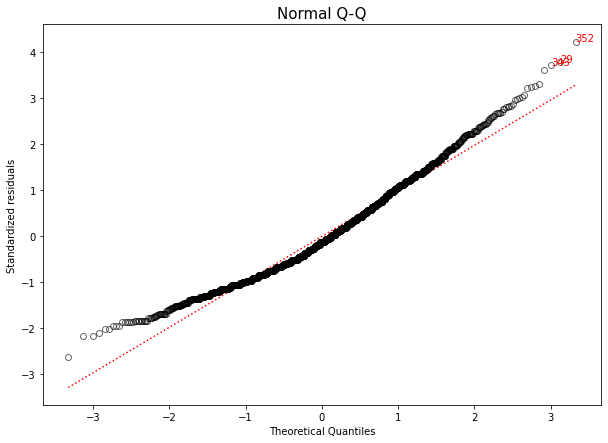

In [111]:
plt.figure(figsize=(10,7))
lmdiag.q_q(reg3)
plt.show()

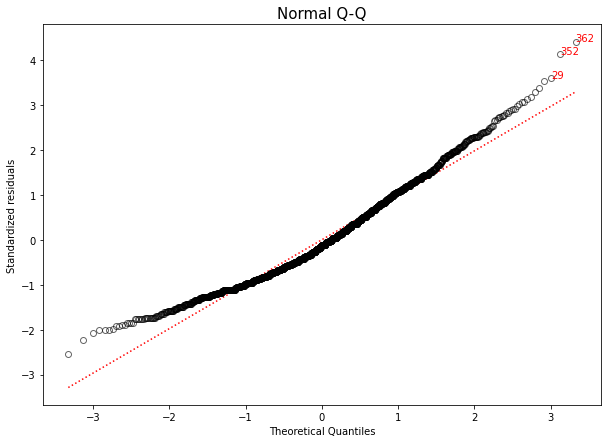

In [112]:
plt.figure(figsize=(10,7))
lmdiag.q_q(reg4)
plt.show()

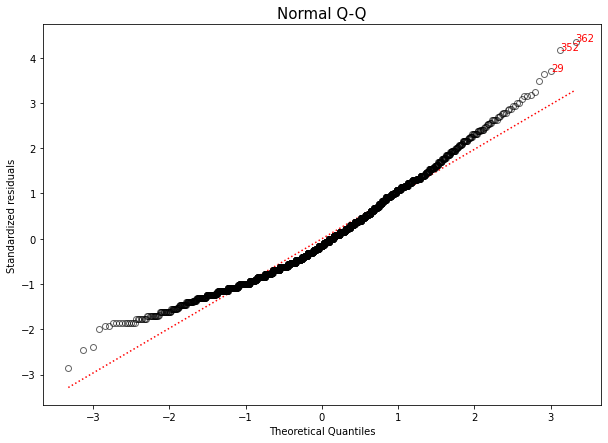

In [113]:
plt.figure(figsize=(10,7))
lmdiag.q_q(reg5)
plt.show()

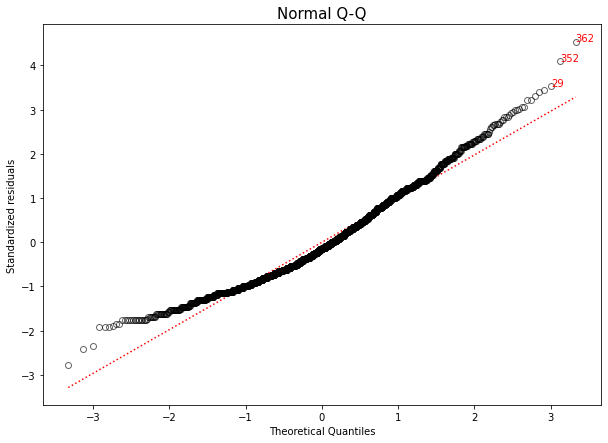

In [114]:
plt.figure(figsize=(10,7))
lmdiag.q_q(reg6)
plt.show()

By checking the residual plots and Quantile-Quantile Plot (QQ-plot) for each proposed model, we can say that the first three assumptions are satisfied for all models as the residual plots for models do not show heteroskedascity. In terms of the last normality assumption, the QQ-plots for these models show that there are a little skewness in error but the amount is insignificant thus we are good to continue. 

## Part 4: Machine Learning

In this section, one of the most popular machine learning algorithms is applied --- Decision Tree. First of all, the objective function here is the square error loss function $L(y_i, \hat{y_i}) = \sum_{i=1}^{N} (y_i - \hat{y}_i)^2$ where N represents the total number of observations, $y_i$ represents the true death age of the suspect, and $\hat{y}_i$ represents the predicted death age. Thus, in order to get the best model, we tend to optimize the objective function (e.g. minimize the loss function). In other words, we would like to minimize the prediction error, that is minimizing the error when predicting the death age of the suspect.

Since to prevent overfitting, I added a regularizer to the loss function so that I would get penalized if I have too many predictors and my loss function would get larger but my goal is to minimize the loss function. Thus, the new objective function is as follows: $L(y_i, \hat{y_i}) = \sum_{m=1}^{|T|} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2 + \alpha|T|$ where $|T|$ is the absolute value of the number of terminal nodes of the decision tree. This loss function will have higher value if there are many terminal nodes, which means the decision tree is too complex and it is not preferred. $\alpha$ is a hyperparameter that we need to tune and it decides how hard the model would be penalized for having too many terminal nodes. If $\alpha$ is large then the loss function would be increased by a large value which is proportional to the number of terminal nodes in the decision tree and vice versa. It is crucial to tune an appropriate $\alpha$ because it is neither desirable to penalize too hard so the final model is too simple nor to have little penalty so that the final model is too complicated and has the risk of overfitting. In both cases, the model would not perform well on new data.

In [115]:
df_merged_sub_tree = df_merged_sub.copy()
X = df_merged_sub_tree.drop(["state_code", "state"], axis=1)
for col in list(X):
    X[col] = X[col].astype(float)
    
# fit the model
age_tree = tree.DecisionTreeRegressor(max_depth=3).fit(X[x2], X["age"])

# make prediction
pred_age = age_tree.predict(X[x2])

# find the error of prediction
mse = metrics.mean_squared_error(X["age"], pred_age)
print("The Mean Squared Error is {}".format(mse))

The Mean Squared Error is 164.2544448035974


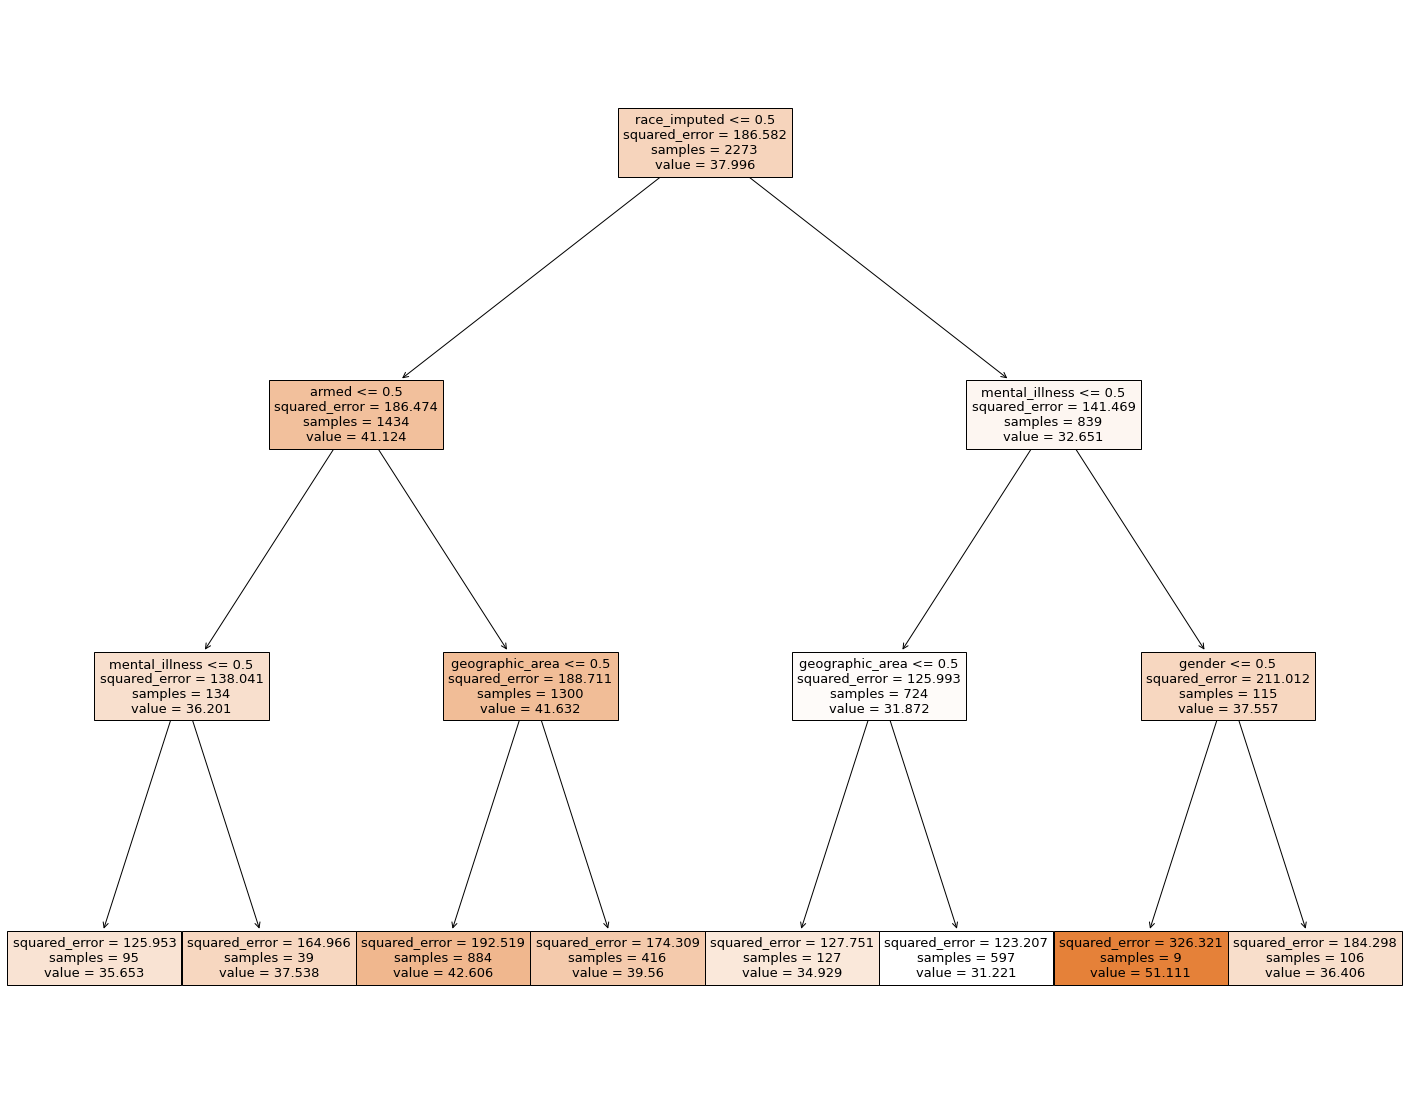

In [116]:
tree_fig = plt.figure(figsize=(25,20))
tree_fig = tree.plot_tree(age_tree, feature_names=X[x2].columns, filled=True)

For each node of the tree, the first line represents the rule of spliting, except the terminal nodes. For example, for the root node, the `race_imputed <= 0.5` means when race is white (`race_imputed = 0`) because race variable is a binary variable. In this decision tree, all of the independent variables are binary variables. The second line displays the squared prediction error based on the corresponding split. For instance, for the root node, the squared error is 185 which means the prediction error is $\sqrt{186} = 13.6$ and it means there are 13.6 years error between the true death age and predicted death age. The third line shows the number of observations that are eligible for the split. In the same example, sample = 2273 in the first root means there are 2273 observations are available to be split based on the condition in the first line. Lastly, we have the value which is simply the predicted value for death age.

The conclusion we can draw from the decision tree is as follows:

- The predicted death age of an unarmed white suspect with no mental illness is 35.7 years old while 37.5 for an unarmed white suspect with mental illness.
- The predicted death age of an armed white suspect in the rural area is 42.6 years old while 39.6 for the same suspect in the urban area.
- The predicted death age of a black suspect with no mental illness in the rural area is 34.9 years old while 31.2 for the same suspect in the urban area.
- The predicted death age of a black female suspect with mental illness is 51.1 years old while 36.4 for a black male suspect with mental illness.
    - It is noticeable that the squared error for the prediction of a black male suspect with mental illness is 326 which is much larger than other squared error. Thus, the prediction may not be reliable.

Here we can observe a pattern that armed suspects have larger death age than unarmed ones which is consistent with the result of linear regression model. Also, the decision tree shows a pattern that suspects with mental health issue would have higher death age compared to suspects with no mental illness. This finding is aligned with the result in linear regression, and thus the pattern can be justified. Other than the similar results from decision tree and linear regression, there are a few extra information we can observe only in decision tree. Firstly, decision tree shows the squared error for each prediction which researchers can see the performance for specific prediction, while linear regression only display the mean squared error which only provide a general performance evaluation. Another advantage of decision tree over linear model is that people can follow the rules to understand the relationship between death age and each predictor. In linear regression there is no visualization to display the process of predicting age based on these predictors. Moreover, in decision tree, we can see the number of observations for each spliting group. The benefit of this is that we can determine whether the poor perfomance of the prediction is due to the lack of training sample or due to model itself.


## Future Steps

There are 3 ways to further improve the analysis. Firstly, collect more individual-level data to run linear regression model to reduce the omitted variable bias. Then using AIC, BIC, ANOVA test to reduce the insignificant predictors to make better prediction. The data at hand is not rich enough to do it. Secondly, using more advanced machine learning algorithms (e.g. Bagging, Random Forest) to make more unbiased predictions. Lastly, more appropriate models should be implemented to account for the random effect in the data (e.g. Linear Mixed Model) since the observations can be grouped based on the states and neighbourhoods. 

## Conclusion

There have been rising questions about the use of force of police officers. And the conflicts between African Americans have been worsen after a few incidences of police killing. Several findings are established. Firstly, by plotting the density curve, we found that the death age of Black people due to police killing is younger than the White people. To be more specific, African Americans' death ages are concentrated around 25 years old whereas Caucasian Americans' death ages are concentrated around 33 years old. Secondly, I found that most states in the middle east part of the US, California, Texas, and Florida have higher police killing frequency than other states, for instance, some states that are in the middle part of the US. Thirdly, by using HTML-based web scraping and folium maps, I created visualizations for the population and the number of drug arrest cases for each state. Hence, I found that the population size and the drug abuse severity have positive correlations with number of police killing cases. Lastly, by running multiple linear regressions and applying supervised machine learning method, we found that a black male suspect's death age due to police shooting is around 10 years earlier than a white female suspect. Also, both decision tree method and linear regression prove that being an armed suspect or a suspect with mental illness would have older death age compared to unarmed suspect or a suspect with no mental illness respectively and prove that in urban area suspect would die at a younger age than in the rural area.

However, the conclusions suffer from the following limitations. Firstly, the regression models are not large enough to account for all potential influential factors on the death age, thus there exists omitted variable bias. Secondly, the linear regression model does not account for clustering effect as observations can be grouped together. Hence, in the future steps, a linear mixed model is more appropriate to use. Thirdly, modelling the relationship of interest by a single decision tree is not rousted to bias, thus in future, a random forest or bagging is strongly recommended.

## Reference

[1] Deliso, M. (2021). Timeline: The impact of George Floyd's death in Minneapolis and beyond. ABC News. Retrieved April 14, 2022, from https://abcnews.go.com/US/timeline-impact-george-floyds-death-minneapolis/story?id=70999322 

[2] Fyfe, J. J. (1982a). Blind justice: Police shootings in Memphis. The Journal of Criminal Law and Criminology, 73, 707-722.

[3] Geller, W. A., & Karales, K. J. (1981). Shootings of and by Chicago police: Uncommon crises—Part I: Shootings by Chicago police. The Journal of Criminal Law and Criminology, 72, 1813-1866.

[4] James, L., James, S. M., & Vila, B. J. (2016). The reverse racism effect. Criminology & Public Policy, 15, 457-479.

[5] Klinger, D., Rosenfeld, R., Isom, R. D., & Deckard, M. (2016). Race, crime, and the micro-ecology of deadly force. Criminology and Public Policy, 15, 193-222.

[6] Milton, C. H., Halleck, J. W., Lardner, L., & Abrecht, G. L. (1977). Police use of deadly force. Washington, DC: Police Foundation.

[7] Nix, J., Campbell, B. A., Byers, E. H., & Alpert, G. P. (2017). A bird’s eye view of civilians killed by police in 2015: Further evidence of shooter bias. Criminology & Public Policy, 16, 1-32.

[8] Reiss, A. J., Jr. (1972). The police and the public. New Haven, CT: Yale University Press.

[9] Solomon, D. (2016, September 27). The intersection of policing and Race. Center for American Progress. Retrieved April 14, 2022, from https://www.americanprogress.org/article/the-intersection-of-policing-and-race/ 

[10] Terrill, W. (2005). Police use of force: A transactional approach. Justice Quarterly, 22, 107-138.

[11] Terrill, W., & Mastrofski, S. D. (2002). Situational and officer-based determinants of police coercion. Justice Quarterly, 19, 215-248.

[12] Worrall et al. (2018). Exploring bias in police shooting decisions with real ... Retrieved April 14, 2022, from https://journals.sagepub.com/doi/10.1177/0011128718756038 